In [1]:
!cat job22/main.sh

#!/bin/bash
set -euxo pipefail

cat ${BASH_SOURCE[0]}

WORKDIR=$(pwd)

STRIDE=0

if [ -v SLURM_ARRAY_TASK_ID ]; then
  SEED="$((SLURM_ARRAY_TASK_ID+STRIDE))"
  WORKDIR="${WORKDIR}/${SLURM_ARRAY_JOB_ID}_${SEED}"
else
  SEED="0"
fi

ROOTDIR="/home/kaizu/t1/ctrw"
cd ${ROOTDIR}

mkdir --parents ${WORKDIR}

TRACER_DIAMETER=`python -c "print([10, 15, 18][(${SEED}%3)])"`
CROWDER_CONSTRAINT_DIAMETER=`python -c "print([0, 16, 28][(${SEED}//3%3)])"`
D_CROWDER=`python -c "print([9.375, 0.3, 0.05][(${SEED}//9%3)])"`
CROWDER_DIAMETER="9.6"
N_CROWDER_RIGHT="692"
DT="1e-9"

# IDX=`python -c "print(${SEED}//(11*17*2))"`
IDX=`python -c "print(${SEED}//27)"`

date

${ROOTDIR}/build/a.out $SEED $TRACER_DIAMETER $CROWDER_CONSTRAINT_DIAMETER $D_CROWDER $CROWDER_DIAMETER $N_CROWDER_RIGHT $DT | tee ${WORKDIR}/result_${TRACER_DIAMETER}_${CROWDER_CONSTRAINT_DIAMETER}_${D_CROWDER}_${CROWDER_DIAMETER}_${N_CROWDER_RIGHT}_${DT}_${IDX}.csv

date


In [2]:
!ls job22

84189_0     84729_3186	       slurm-84189_100.out   slurm-84729_318.out
84189_1     84729_3187	       slurm-84189_101.out   slurm-84729_3190.out
84189_10    84729_3188	       slurm-84189_102.out   slurm-84729_3191.out
84189_100   84729_3189	       slurm-84189_103.out   slurm-84729_3192.out
84189_101   84729_319	       slurm-84189_104.out   slurm-84729_3193.out
84189_102   84729_3190	       slurm-84189_105.out   slurm-84729_3194.out
84189_103   84729_3191	       slurm-84189_106.out   slurm-84729_3195.out
84189_104   84729_3192	       slurm-84189_107.out   slurm-84729_3196.out
84189_105   84729_3193	       slurm-84189_108.out   slurm-84729_3197.out
84189_106   84729_3194	       slurm-84189_109.out   slurm-84729_3198.out
84189_107   84729_3195	       slurm-84189_10.out    slurm-84729_3199.out
84189_108   84729_3196	       slurm-84189_110.out   slurm-84729_319.out
84189_109   84729_3197	       slurm-84189_111.out   slurm-84729_31.out
84189_11    84729_3198	       slurm-84189_112.out   slur

In [3]:
import glob, sys, os.path, itertools, pathlib
from collections import defaultdict
import numpy

In [4]:
artifacts = pathlib.Path("./artifacts")

In [5]:
sys.path.append("/home/kaizu/t1/ctrw")
import scripts.io

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams["figure.dpi"] = 120

In [7]:
interval = 0.004
L1 = 0.149

In [8]:
N_tracer = 10
deltax = 0.050

In [9]:
fmt = "job22/84729_*/result_*_*_*_*_*_*_*.csv"
filenames1 = glob.glob(fmt)
print(len(filenames1))
filenames1 = scripts.io.clasify_files(filenames1)

5400


In [10]:
def read_file3d(filename, L=None, data=None, sp=None):
    data = data or defaultdict(list)
    
    tmp = defaultdict(lambda : defaultdict(list))
    with filename.open("r") as f:
        for line in f:
            if line.startswith('#'):
                continue
            row = line.strip().split(",")
            assert len(row) == 6
            t_, sp_, idx_, x_, y_, z_ = row
            t, idx, x, y, z = float(t_), int(idx_), float(x_), float(y_), float(z_)

            # assert sp_ == "X"
            if sp is not None and sp_ != sp:
                continue

            if L is not None:
                x, y, z = x % L, y % L, z % L

            tmp[sp_][idx].append(numpy.array([t, x, y, z]))
    
    for sp, positions in tmp.items():
        data[sp].extend(numpy.array(value) for _, value in positions.items())
    return data

def read_files3d(filenames, L=None, sp=None):
    data = {}
    for filename in filenames:
        if isinstance(filename, str):
            filename = pathlib.Path(filename)
        data = read_file3d(filename, L, data, sp)
    return data

In [11]:
data1 = {}
for key, filenames in filenames1.items():
    data_ = read_files3d(filenames)
    data1[key] = data_

In [12]:
displacements = {}
for key, data in data1.items():
    displacements[key] = {}
    for sp, positions in data.items():
        # print(f"{key}, {sp}, {len(positions)}")
        t = positions[0].T[0]  # t
        # msd = sum((x - x[0]).T[2] ** 2 for x in positions) / len(positions)  # Y        
        msd = sum(sum((x - x[0]).T[1: ] ** 2) for x in positions) / len(positions)  # R
        displacements[key][sp] = (t, msd)

In [13]:
def replace_at_index(tup, idx, val):
    lst = list(tup)
    lst[idx] = val
    return tuple(lst)

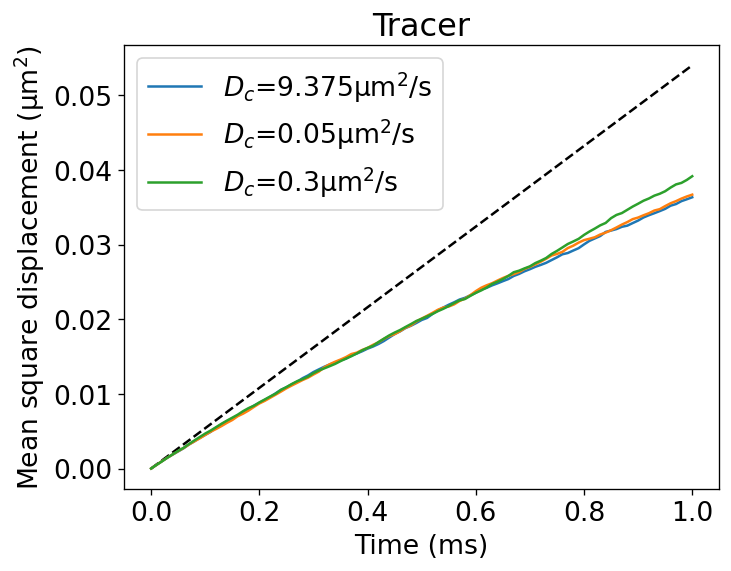

In [14]:
key1 = ('10', '0', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

D = 90 / float(key1[0])
ax1.plot(displacements[key1]["X"][0] * 1000, 6 * D * displacements[key1]["X"][0], 'k--')

for D_crowder_ in ('9.375', '0.05', '0.3'):
    newkey = replace_at_index(key1, 2, D_crowder_)
    ax1.plot(displacements[newkey]["X"][0] * 1000, displacements[newkey]["X"][1], '-', label=rf"$D_c$={D_crowder_}$\mathrm{{\mu m^2/s}}$")

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(r"Mean square displacement ($\mathrm{\mu m^2}$)")
plt.legend(loc='best')
plt.title("Tracer")
fig.savefig(artifacts / 'Mobile_Immobile2-01.svg', format='svg')
plt.show()

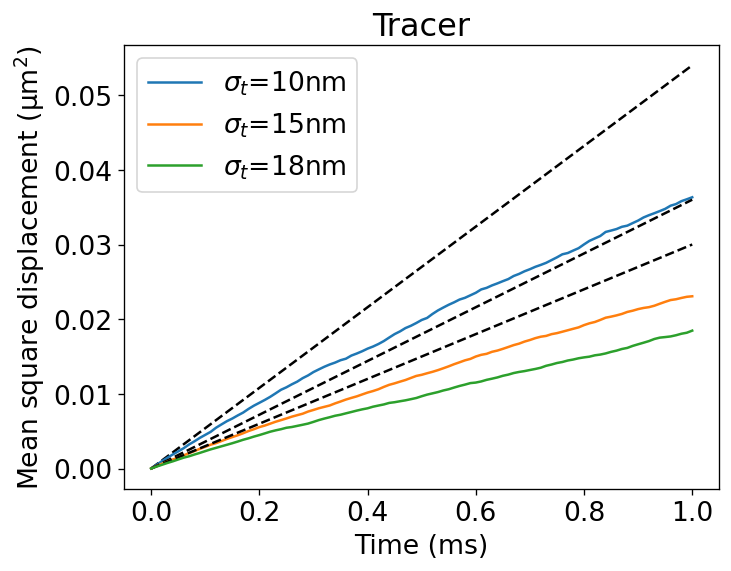

In [15]:
key1 = ('10', '0', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

for tracer_diameter_ in ('10', '15', '18'):
    newkey = replace_at_index(key1, 0, tracer_diameter_)
    ax1.plot(displacements[newkey]["X"][0] * 1000, 6 * (90 / float(tracer_diameter_)) * displacements[newkey]["X"][0], 'k--')
    ax1.plot(displacements[newkey]["X"][0] * 1000, displacements[newkey]["X"][1], '-', label=rf"$\sigma_t$={tracer_diameter_}nm")

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(r"Mean square displacement ($\mathrm{\mu m^2}$)")
plt.legend(loc='best')
plt.title("Tracer")
fig.savefig(artifacts / 'Mobile_Immobile2-02.svg', format='svg')
plt.show()

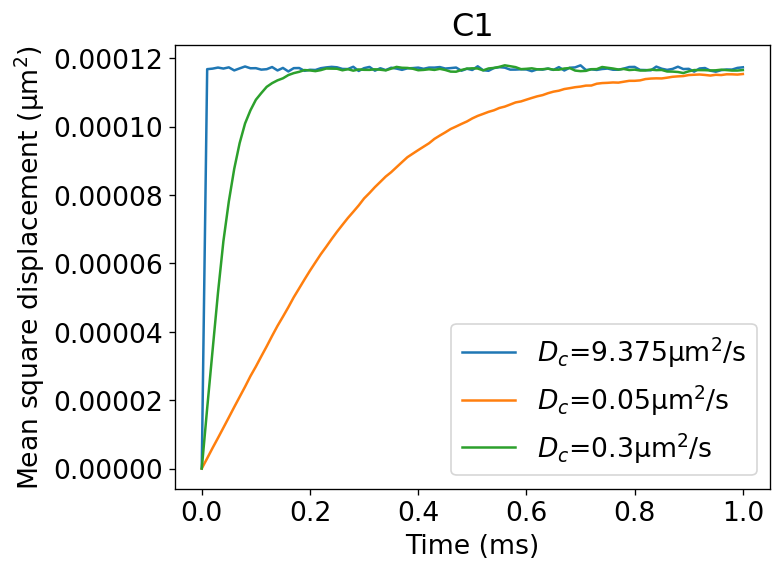

In [16]:
key1 = ('10', '28', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

D = 90 / float(key1[0])
# ax1.plot(displacements[key1]["X"][0] * 1000, 2 * D * displacements[key1]["X"][0], 'k--')

for D_crowder_ in ('9.375', '0.05', '0.3'):
    newkey = replace_at_index(key1, 2, D_crowder_)
    ax1.plot(displacements[newkey]["C1"][0] * 1000, displacements[newkey]["C1"][1], '-', label=rf"$D_c$={D_crowder_}$\mathrm{{\mu m^2/s}}$")

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(r"Mean square displacement ($\mathrm{\mu m^2}$)")
plt.legend(loc='best')
plt.title("C1")
fig.savefig(artifacts / 'Mobile_Immobile2-03.svg', format='svg')
plt.show()

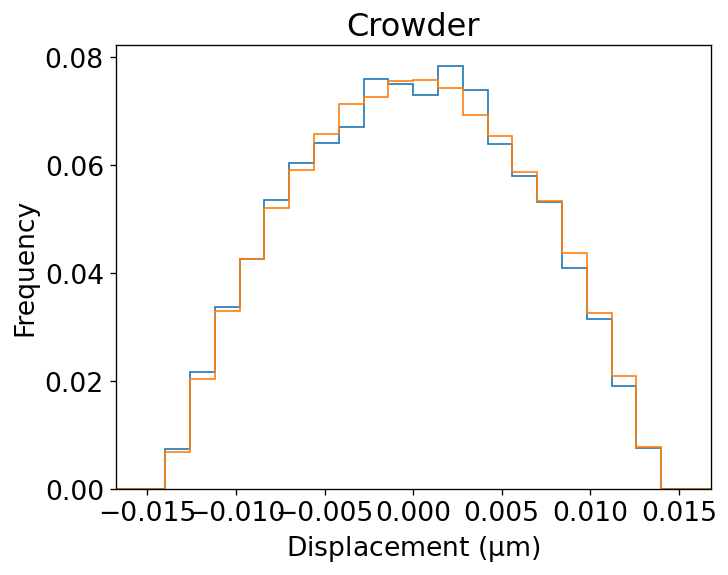

In [17]:
key1 = ('10', '28', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

constraint_radius = 0.014
bins = numpy.linspace(-constraint_radius * 1.2, +constraint_radius * 1.2, 25)

x = numpy.array([(x - x[0])[-1] for x in data1[key1]["C1"]]).T[2]
counts, _ = numpy.histogram(x, bins=bins)
plt.stairs(counts / sum(counts), bins)

x = numpy.array([(x - x[0])[-1] for x in data1[key1]["C2"]]).T[2]
counts, _ = numpy.histogram(x, bins=bins)
plt.stairs(counts / sum(counts), bins)

plt.xlim(bins.min(), bins.max())
plt.ylabel("Frequency")
plt.xlabel(r"Displacement ($\mathrm{\mu m}$)")
plt.title("Crowder")
fig.savefig(artifacts / 'Mobile_Immobile2-04.svg', format='svg')
plt.show()

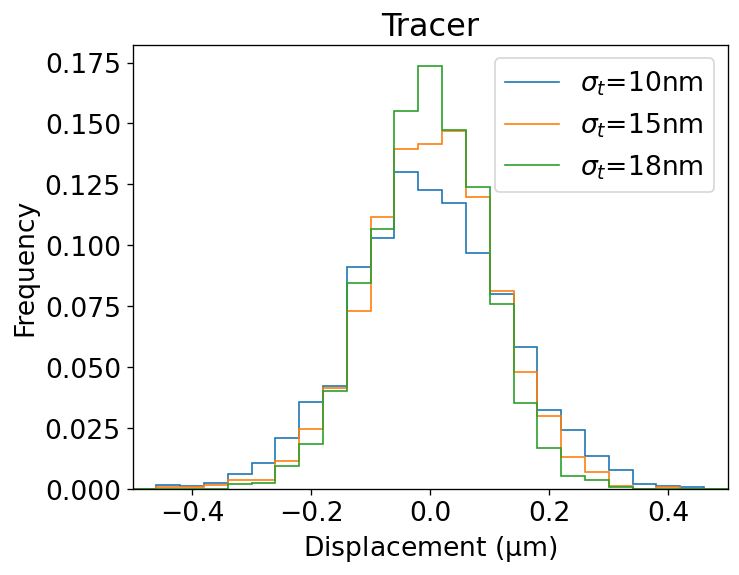

In [18]:
key1 = ('10', '28', '9.375', '9.6', '692', '1e-9')

bins = numpy.linspace(-0.5, +0.5, 26)

fig, ax1 = plt.subplots()

for tracer_diameter_ in ('10', '15', '18'):
    x = numpy.array([(x - x[0])[-1] for x in data1[replace_at_index(key1, 0, tracer_diameter_)]["X"]]).T[2]
    counts, _ = numpy.histogram(x, bins=bins)
    plt.stairs(counts / sum(counts), bins, label=fr"$\sigma_t$={tracer_diameter_}nm")

plt.xlim(bins.min(), bins.max())
plt.ylabel("Frequency")
plt.xlabel(r"Displacement ($\mathrm{\mu m}$)")
plt.title("Tracer")
plt.legend(loc='best')
fig.savefig(artifacts / 'Mobile_Immobile2-05.svg', format='svg')
plt.show()